# 300W-LP Dataset Preparation

The dataset has the following format: <br>
``` text
300W_LP/
├── AFW/
│   ├── AFW_134212_1_0.jpg
│   ├── AFW_134212_1_0.mat   <-- Contains the pose labels
│   ├── AFW_134212_1_1.jpg
│   └── ...
├── HELEN/
│   ├── HELEN_232131_1_0.jpg
│   ├── HELEN_232131_1_0.mat
│   └── ...
├── IBUG/
│   └── ...
├── LFPW/
│   └── ...
└── landmarks

It will be turned into an Images folder and a labels.csv file.

In [1]:
import numpy as np, os, pandas as pd, shutil, scipy.io, matplotlib.pyplot as plt, PIL.Image as Image
os.chdir('..')

In [2]:
dataset_dir = os.path.join('data', 'datasets', 'head pose estimation', '300W_LP')
os.path.exists(dataset_dir)

True

In [3]:
subdatasets = ['AFW', 'AFW_Flip', 'HELEN', 'HELEN_Flip', 'IBUG', 'IBUG_Flip', 'LFPW', 'LFPW_Flip']

In [4]:
new_images_dir = os.path.join(dataset_dir, 'Images')
os.makedirs(new_images_dir, exist_ok = True)

## Preprocessing

In [5]:
image_names = []
rolls = []
pitches = []
yaws = []
counter = 0
for subdataset in subdatasets:
    old_images_dir = os.path.join(dataset_dir, subdataset)
    image_files = [f for f in os.listdir(old_images_dir) if f.endswith('.jpg')] # only .jpg files
    
    for image_file in image_files:
        image_path = os.path.join(old_images_dir, image_file)
        mat_path = image_path.replace('.jpg', '.mat')

        mat_data = scipy.io.loadmat(mat_path)
        pose_parameters = mat_data['Pose_Para'].flatten()
        
        pitch_rad = pose_parameters[0]
        yaw_rad = pose_parameters[1]
        roll_rad = pose_parameters[2]

        # to degrees
        pitch_deg = pitch_rad * (180 / np.pi)
        yaw_deg = yaw_rad * (180 / np.pi)
        roll_deg = roll_rad * (180 / np.pi)
         
        image = Image.open(image_path)
        image = image.resize((112, 112))
        image.save(
            os.path.join(new_images_dir, f'{counter}.jpg')
        )

        yaws.append(yaw_deg)
        pitches.append(pitch_deg)
        rolls.append(roll_deg)
        image_names.append(f'{counter}.jpg')

        counter += 1


In [6]:
labels_df = pd.DataFrame(
    data = {
        'filename' : image_names,
        'yaw' : yaws,
        'pitch' : pitches,
        'roll' : rolls
    }
)

labels_df.to_csv(
    os.path.join(dataset_dir, 'labels.csv'),
    index = False
)

# EDA

In [7]:
labels_df = pd.read_csv(os.path.join(dataset_dir, 'labels.csv'))

In [8]:
labels_df.head()

,filename,yaw,pitch,roll
0,0.jpg,-36.041874,-3.884707,-4.415520
1,1.jpg,-40.841663,11.548470,-0.073107
2,2.jpg,-55.772015,3.308969,2.917549
3,3.jpg,-59.145871,-2.327920,-7.009118
4,4.jpg,51.624222,-18.141396,-18.483711


In [9]:
import cv2
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size=50):
    """
    img: numpy array (H, W, 3) or (H, W) - Input image
    yaw, pitch, roll: angles in degrees
    tdx, tdy: Center of the face (x, y). If None, uses image center.
    size: Length of the axis lines
    """
    # Convert degrees to radians
    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180) 
    roll = roll * np.pi / 180

    if tdx is None or tdy is None:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in Red
    x1 = size * (np.cos(yaw) * np.cos(roll)) + tdx
    y1 = size * (np.cos(pitch) * np.sin(roll) + np.cos(roll) * np.sin(pitch) * np.sin(yaw)) + tdy

    # Y-Axis | drawn in Green
    #        v
    x2 = size * (-np.cos(yaw) * np.sin(roll)) + tdx
    y2 = size * (np.cos(pitch) * np.cos(roll) - np.sin(pitch) * np.sin(yaw) * np.sin(roll)) + tdy

    # Z-Axis (out of screen) drawn in Blue
    x3 = size * (np.sin(yaw)) + tdx
    y3 = size * (-np.cos(yaw) * np.sin(pitch)) + tdy

    # Draw the lines
    # OpenCV uses BGR, so (0,0,255) is Red, (0,255,0) is Green
    img = img.copy() # Don't modify original
    
    # Pitch (X-axis) - Red
    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(255, 0, 0),2)
    # Yaw (Y-axis) - Green
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),2)
    # Roll (Z-axis) - Blue
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(0, 0, 255),2)

    return img

In [10]:
figures_dir = os.path.join('data', 'figures', 'Pose estimation', '300W-LP')
os.makedirs(figures_dir, exist_ok = True)

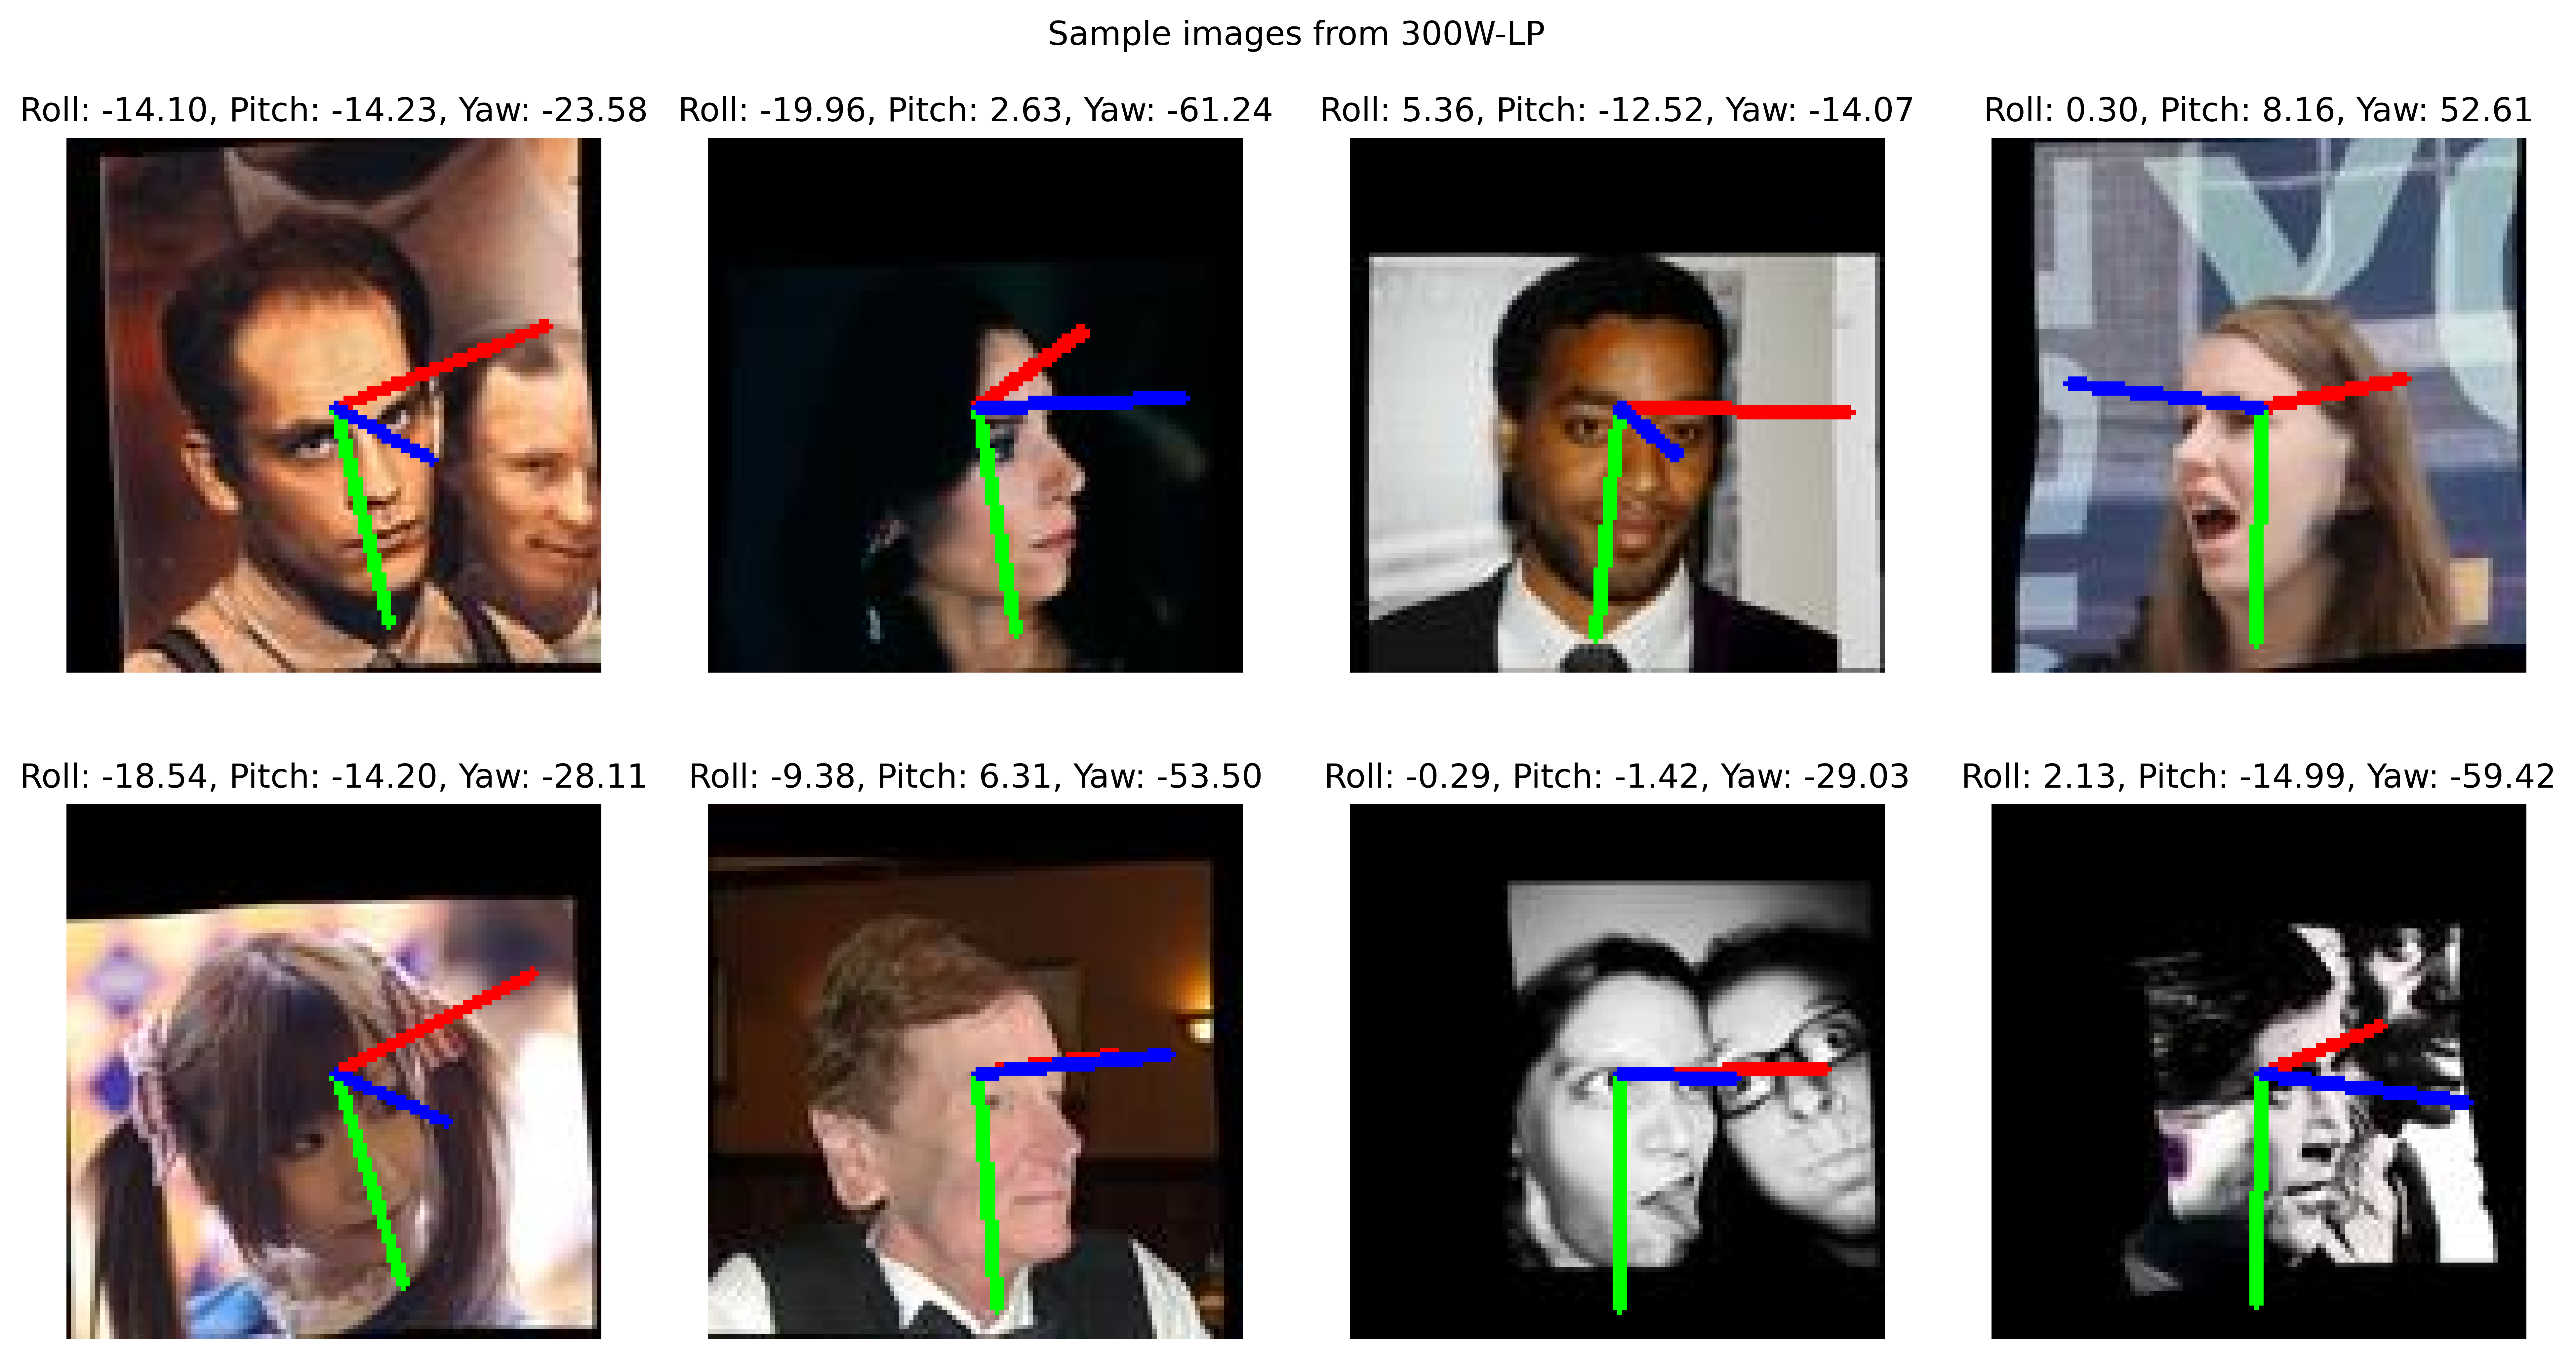

In [12]:
plt.figure(figsize = (16, 8), dpi = 600)
plt.axis('off')
plt.title('Sample images from 300W-LP', pad = 30)
for i in range(8):
    index = np.random.randint(low = 0, high = len(labels_df))
    image = cv2.imread(
        os.path.join(new_images_dir, labels_df.filename[index]),
        cv2.IMREAD_COLOR_RGB
    )
    roll = labels_df.roll[index]
    pitch = labels_df.pitch[index]
    yaw = labels_df.yaw[index]
    image = draw_axis(image, yaw = yaw, pitch = pitch, roll = roll)

    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(f'Roll: {roll:.2f}, Pitch: {pitch:.2f}, Yaw: {yaw:.2f}')
    plt.axis('off')
plt.savefig(
    os.path.join(figures_dir, 'sample images')
)
plt.show()